
# Development of a predictive model & evaluation

## Target variable
Target Variable: ***covid19_positive***
For this classification task, the target variable selected was `covid19_positive`, which indicates whether a participant has tested positive for COVID-19.

Justification:

*   Binary classification suitability: `covid19_positive` is a binary variable (0 = not tested positive, 1 = tested positive), making it well-suited for supervised classification models like Decision Trees, K-Nearest Neighbors (KNN), and Naïve Bayes.

*   Relevant to public health: Predicting the likelihood of testing positive for COVID-19 is a meaningful and realistic application. It can assist in identifying at-risk individuals based on health status, symptoms, and exposure history.
*   Balanced class distribution: The dataset demonstrates a reasonably balanced class distribution (~60% negative, ~40% positive), which supports reliable model training. This balance reduces the need for complex re-sampling techniques or synthetic data generation to mitigate class imbalance issues.

Overall, covid19_positive is a practical, meaningful, and technically suitable target variable for binary classification within this dataset. For this reason, two classification algorithms were selected for modelling: a Decision Tree and K-Nearest Neighbors (KNN), both well-suited to binary classification problems.

## Input feature variable sets
**Features to use:**

| Feature                  | Reason                                                                       |
| ------------------------ | ---------------------------------------------------------------------------- |
| `gender` `age (5+-)` `bmi` `blood_type`          |  Demographics - bmi is derived from height and weight so can keep it instead of height/weight                         |
| `insurance` `income` `smoking` `alcohol` `cocaine` |  Socioeconomic and Behavioral Factors                       |
| `contacts_count` `public_transport_count` `working` `worried ` |  Exposure Risk Indicators - worried may reflect cautious behavior or exposure perception                     |
| `asthma` `kidney_disease` `liver_disease` `compromised_immune` `heart_disease` `lung_disease` `diabetes` `hiv_positive` `other_chronic` |  Pre-existing Conditions                   |
| `nursing_home` `health_worker` |  Living/Occupation Situation               |

**Features to drop:**

| Feature                         | Reason                                            |
| ------------------------------- | ------------------------------------------------- |
| `Participant_ID `                    | Just an identifier               |
| `survey_date `                    | Can’t generalize to other time periods              |
| `region` `country `                     | May introduce geographic bias               |
| `ip_latitude` `ip_longitude`                   | Very granular, privacy risk, and may overfit to location              |
| `height (m) ` `weight (kg)`                   | Redundant if `bmi` is included              |
| `covid19_symptoms `                    | **Leaky**: symptoms occur after infection              |
| `covid19_contact  `                    | Also **leaky**: often known after testing             |
| `risk_infection ` `risk_mortality `                    | Calculated by the same system
| `risk_infection_level  `                    | Derived from risk_infection and potentially also **leaky**               |


### Import fix change float64 to int64

In [21]:
# Import all Python libraries here...
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

# Read dataset from file...
df = pd.read_csv('/content/drive/MyDrive/Machine-Learning-Project/Dataset-processed.csv')

# print dataset...
print(df.info())

# Function to convert float columns that contain only integer values into actual int type
def convert_float_columns_to_int(df):
    # Loop through all columns in the DataFrame with dtype float64
    for col in df.select_dtypes(include=['float64']).columns:
        # Check if all non-NaN values are whole numbers (i.e., equal to their integer version)
        if np.all(df[col].dropna() == df[col].dropna().astype(int)):
            # If so, safely convert the column from float64 to int64
            df[col] = df[col].astype(int)
            print(f"Converted '{col}' from float64 to int64.")
    # Return the updated DataFrame
    return df

# Apply it to KNN dataset
df = convert_float_columns_to_int(df)

# print dataset
print(df.info())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5718 entries, 0 to 5717
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Participant_ID          5718 non-null   int64  
 1   survey_date             5718 non-null   object 
 2   region                  5718 non-null   object 
 3   country                 5718 non-null   object 
 4   ip_latitude             5718 non-null   float64
 5   ip_longitude            5718 non-null   float64
 6   gender                  5718 non-null   int64  
 7   age (5+-)               5718 non-null   int64  
 8   height (m)              5718 non-null   int64  
 9   weight (kg)             5718 non-null   int64  
 10  bmi                     5718 non-null   float64
 11  blood_type              5718 non-null   int64  
 12  insurance        

,Skewness,Skew Interpretation
nursing_home,16.82,Strong right skew
hiv_positive,16.03,Strong right skew
liver_disease,11.27,Strong right skew
kidney_disease,9.45,Strong right skew
risk_mortality,7.25,Strong right skew
cocaine,6.63,Strong right skew
public_transport_count,6.44,Strong right skew
lung_disease,6.38,Strong right skew
heart_disease,5.47,Strong right skew
compromised_immune,3.73,Strong right skew


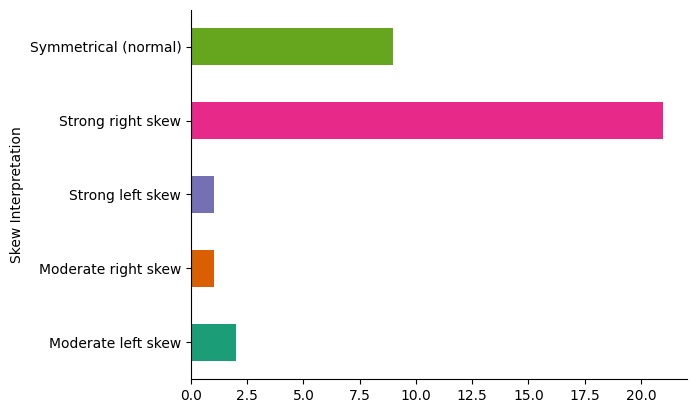

In [22]:
#Function to display a table of skewness

# could look at the other variables and convert them to check for skewness as is said in task 2.3
# Select only the numeric columns from the DataFrame
numeric_cols = df.select_dtypes(include=[np.number])

# Calculate skewness for each numeric column
skew_values = numeric_cols.skew()

# Define a function to classify skewness based on its value
def classify_skew(value):
    if value > 1:
        return "Strong right skew"
    elif 0.5 < value <= 1:
        return "Moderate right skew"
    elif -0.5 <= value <= 0.5:
        return "Symmetrical (normal)"
    elif -1 <= value < -0.5:
        return "Moderate left skew"
    else:
        return "Strong left skew"

# Combine skewness and their interpretations into a table
skew_table = pd.DataFrame({
    'Skewness': skew_values.round(2),                      # Rounded skew values
    'Skew Interpretation': skew_values.apply(classify_skew),  # Apply skew classification
}).sort_values(by='Skewness', ascending=False)  # Sort the table by skewness for readability

# Display the resulting table
display(skew_table)

# Function to display a chart of skewness
# Group the skew_table by interpretation labels (e.g., 'Strong right skew') and count how many variables fall into each category
skew_table.groupby('Skew Interpretation').size().plot(
    kind='barh',  # Create a horizontal bar plot
    color=sns.palettes.mpl_palette('Dark2')  #color palette from Seaborn
)
plt.gca().spines[['top', 'right']].set_visible(False)

### Drop features from dataframe

In [23]:
# List of columns to remove from dataset
non_input_features = ['Participant_ID', 'survey_date','region','country', 'ip_latitude', 'ip_longitude', 'height (m)', 'weight (kg)', 'covid19_symptoms', 'covid19_contact', 'risk_infection', 'risk_mortality']  # Add more if needed

# Drop them from cleaned dataset
df_input = df.drop(columns=non_input_features)

# print dataset...
print(df_input.info())
display(df_input)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5718 entries, 0 to 5717
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gender                  5718 non-null   int64  
 1   age (5+-)               5718 non-null   int64  
 2   bmi                     5718 non-null   float64
 3   blood_type              5718 non-null   int64  
 4   insurance               5718 non-null   int64  
 5   income                  5718 non-null   int64  
 6   smoking                 5718 non-null   int64  
 7   alcohol                 5718 non-null   int64  
 8   cocaine                 5718 non-null   int64  
 9   contacts_count          5718 non-null   int64  
 10  public_transport_count  5718 non-null   int64  
 11  working                 5718 non-null   int64  
 12  worried                 5718 non-null   int64  
 13  covid19_positive        5718 non-null   int64  
 14  asthma                  5718 non-null   

,gender,age (5+-),bmi,blood_type,insurance,income,smoking,alcohol,cocaine,contacts_count,...,kidney_disease,liver_disease,compromised_immune,heart_disease,lung_disease,diabetes,hiv_positive,other_chronic,nursing_home,health_worker
0,0,35,30.2,0,0,0,0,0,0,10,...,0,0,0,0,0,0,0,0,0,0
1,0,35,23.3,1,1,3,0,1,1,6,...,0,0,0,0,0,1,0,0,0,0
2,1,65,29.0,3,1,3,0,1,0,5,...,0,0,0,0,0,0,0,0,0,0
3,0,45,47.3,3,1,4,1,0,0,4,...,0,0,0,1,0,1,0,0,0,0
4,0,25,22.5,0,1,4,0,1,0,6,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5713,0,45,26.4,0,0,0,0,1,0,10,...,0,0,0,0,0,0,0,0,0,0
5714,0,55,27.7,3,0,0,0,1,0,3,...,0,0,0,0,0,0,0,0,0,0
5715,0,35,31.8,7,0,0,0,1,0,21,...,0,0,0,0,0,0,0,0,0,0
5716,1,35,22.8,3,0,0,0,0,0,10,...,0,0,0,0,0,0,0,0,0,0


### Convert all Categorical that arent ordinally encoded or binary into Onehot encoding

In [24]:
# Convert all Categorical that arent ordinally encoded or binary into Onehot encoding
df_input = pd.get_dummies(df_input, columns=['blood_type','age (5+-)'], drop_first=True)
print(df_input.info())
display(df_input)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5718 entries, 0 to 5717
Data columns (total 39 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gender                  5718 non-null   int64  
 1   bmi                     5718 non-null   float64
 2   insurance               5718 non-null   int64  
 3   income                  5718 non-null   int64  
 4   smoking                 5718 non-null   int64  
 5   alcohol                 5718 non-null   int64  
 6   cocaine                 5718 non-null   int64  
 7   contacts_count          5718 non-null   int64  
 8   public_transport_count  5718 non-null   int64  
 9   working                 5718 non-null   int64  
 10  worried                 5718 non-null   int64  
 11  covid19_positive        5718 non-null   int64  
 12  asthma                  5718 non-null   int64  
 13  kidney_disease          5718 non-null   int64  
 14  liver_disease           5718 non-null   

,gender,bmi,insurance,income,smoking,alcohol,cocaine,contacts_count,public_transport_count,working,...,blood_type_7,blood_type_8,age (5+-)_15,age (5+-)_25,age (5+-)_35,age (5+-)_45,age (5+-)_55,age (5+-)_65,age (5+-)_75,age (5+-)_105
0,0,30.2,0,0,0,0,0,10,0,3,...,False,False,False,False,True,False,False,False,False,False
1,0,23.3,1,3,0,1,1,6,0,3,...,False,False,False,False,True,False,False,False,False,False
2,1,29.0,1,3,0,1,0,5,0,3,...,False,False,False,False,False,False,False,True,False,False
3,0,47.3,1,4,1,0,0,4,0,3,...,False,False,False,False,False,True,False,False,False,False
4,0,22.5,1,4,0,1,0,6,0,3,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5713,0,26.4,0,0,0,1,0,10,0,4,...,False,False,False,False,False,True,False,False,False,False
5714,0,27.7,0,0,0,1,0,3,0,4,...,False,False,False,False,False,False,True,False,False,False
5715,0,31.8,0,0,0,1,0,21,0,4,...,True,False,False,False,True,False,False,False,False,False
5716,1,22.8,0,0,0,0,0,10,0,4,...,False,False,False,False,True,False,False,False,False,False


### Normalisation & Skewness

Features to normalise for KNN - Decision Trees do not need normalisation as they split data based on thresholds rather than distance

| Feature Name                | Why?                      |
| ------------------------ - | ------------------------- |
| `bmi`                         | Continuous                |
| `contacts_count`              | High variance             |
| `public_transport_count`    | High variance             |
| `worried`                     | Ordinal scale - small scale but values between each are the same so 0-1 is the same as the distance between 4-5           |


In [25]:
# Decision Trees are unaffected by feature scale, so normalization is not required
df_tree = df_input

from sklearn.preprocessing import MinMaxScaler
# KNN relies on distance metrics, so numeric features must be normalized to ensure equal contribution to distance calculations
#KNN data
df_KNN = df_input

### NORMALISATION
# Features to scale/normalisation
columns_to_normalise = ['bmi', 'contacts_count', 'public_transport_count', 'worried']

# Apply MinMaxScaler
scaler = MinMaxScaler()
df_KNN[columns_to_normalise] = scaler.fit_transform(df_KNN[columns_to_normalise])

# verify scaling worked
print(df_KNN[columns_to_normalise].describe())

### ADDRESSING SKEWNESS
#public_transport_count & contacts_count are heavily right skewed and need to be addressed for KNN to intrepret them properly
#Other heavly right skewwed features are either binary 0-1 or have been converted to binary 0-1

#due to the domination of 0's in public_transport_count applying log1p and sqrt to address its skewness had little impact.
# applied binning to it to address the skewness - down from 5.68 - 3.33. this is the best I can get it without transforming the variable into something like "have you used public transport in the past 2 weeks 0/1" rather than
# "how many times did you use public transport in the past 2 weeks"

# Discretize the 'public_transport_count' feature into categorical bins
df_KNN['public_transport_bin'] = pd.cut(
    df_KNN['public_transport_count'],
    # Define bin edges:
    # -0.1 to 0   → bin 0 (no public transport)
    # >0 to 2     → bin 1 (low use)
    # >2 to 5     → bin 2 (moderate use)
    # >5 to ∞     → bin 3 (high use)
    bins=[-0.1, 0, 2, 5, float('inf')],

    # Assign numeric labels to each bin
    labels=[0, 1, 2, 3]
).astype(int)  # Convert the resulting categorical values to integer type


df_KNN['contacts_count'] = np.log1p(df_KNN['contacts_count'])

               bmi  contacts_count  public_transport_count      worried
count  5718.000000     5718.000000             5718.000000  5718.000000
mean      0.147317        0.373008                0.021989     0.554914
std       0.067780        0.317645                0.108094     0.321906
min       0.000000        0.000000                0.000000     0.000000
25%       0.102564        0.142857                0.000000     0.400000
50%       0.131742        0.238095                0.000000     0.600000
75%       0.175950        0.476190                0.000000     0.800000
max       1.000000        1.000000                1.000000     1.000000


Before binning skew: 6.436232027795753
After binning skew: 3.331270633357772


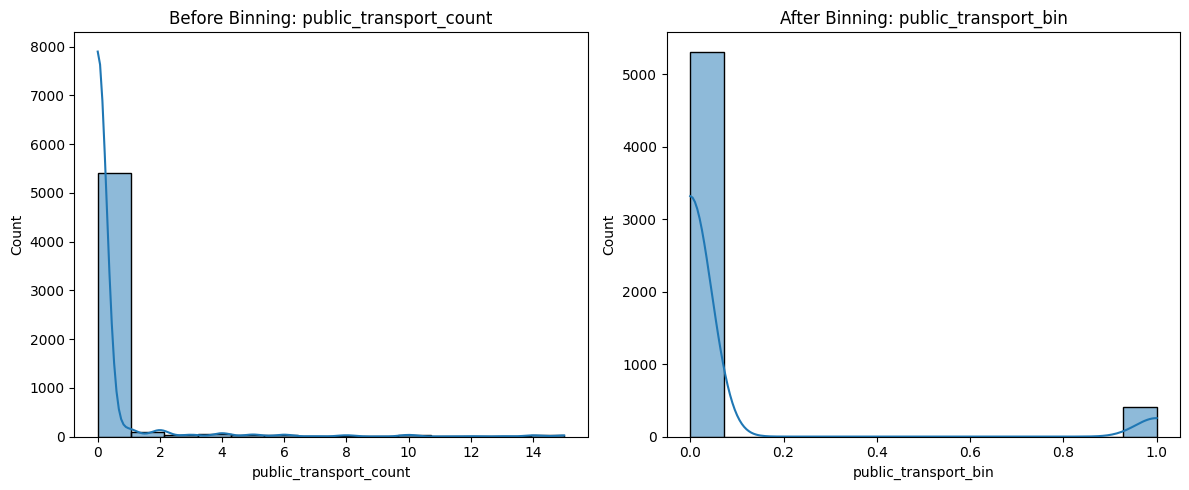

In [26]:
# Before & after binning transformation
# Print skewness values
print("Before binning skew:", df['public_transport_count'].skew())
print("After binning skew:", df_KNN['public_transport_bin'].skew())

# Create side-by-side histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogram before binning
sns.histplot(df['public_transport_count'], kde=True, ax=axes[0])
axes[0].set_title('Before Binning: public_transport_count')

# Histogram after binning
sns.histplot(df_KNN['public_transport_bin'], kde=True, ax=axes[1])
axes[1].set_title('After Binning: public_transport_bin')

plt.tight_layout()
plt.show()

Before log1p skew: 0.9279698203762332
After log1p skew: 0.6844752474441979


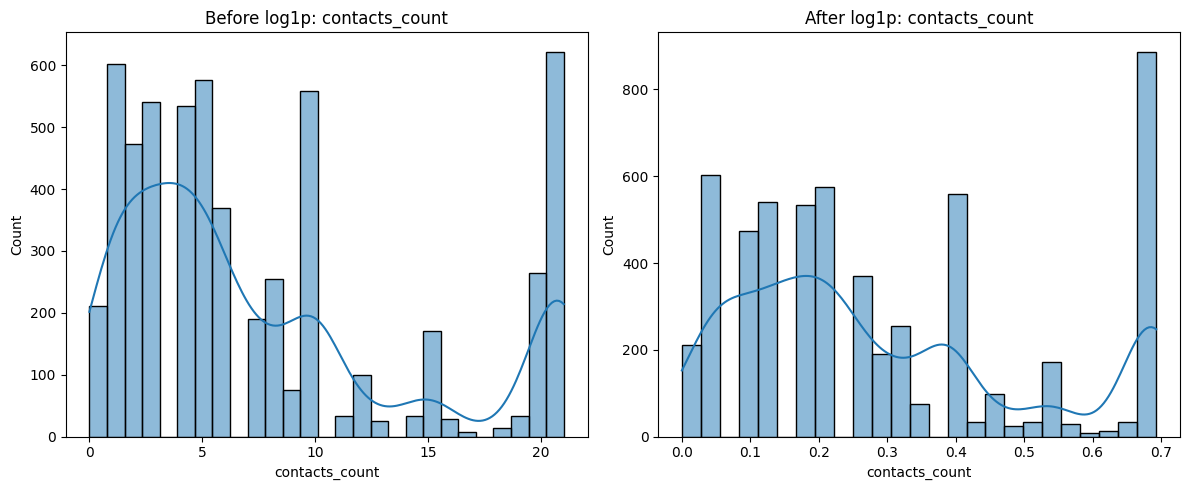

In [27]:
# Before & after log1p transformation
# Print skewness values
print("Before log1p skew:", df['contacts_count'].skew())
print("After log1p skew:", df_KNN['contacts_count'].skew())

# Create side-by-side histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogram before log1p
sns.histplot(df['contacts_count'], kde=True, ax=axes[0])
axes[0].set_title('Before log1p: contacts_count')

# Histogram after log1p
sns.histplot(df_KNN['contacts_count'], kde=True, ax=axes[1])
axes[1].set_title('After log1p: contacts_count')

plt.tight_layout()
plt.show()

In [28]:
# apply Onehot encoding to public_transport_count only for KNN and now that its BINNED (technically categorical)
df_KNN = pd.get_dummies(df_input, columns=['public_transport_bin'], drop_first=True)

## Classification algorithms
(Using two classification algorithms (e.g. decisions trees, Naive Bayes or KNN) to build two classification models & train the models using the processed dataset with the selected features in 2) as the input features)

### Decision Tree

#### Split features

In [29]:
# Separate features and target
# 'X' contains all input features, excluding the target column
# 'y' is the target variable — whether the individual is COVID-positive
X = df_tree.drop(columns=['covid19_positive'])
y = df_tree['covid19_positive']

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

# Split the dataset into training and testing sets (70% train, 30% test)
# random_state=42 ensures reproducibility
# stratify=y ensures that both classes (positive and negative) are proportionally represented in both splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

#### Gridsearch best parameters

In [30]:
# Define a grid of hyperparameters to tune for the Decision Tree
param_grid = {
    'max_depth': [5, 10, 15],             # Maximum depth of the tree
    'min_samples_split': [10, 20],        # Minimum samples required to split an internal node
    'min_samples_leaf': [5, 10],          # Minimum samples required at a leaf node
    'criterion': ['gini', 'entropy']      # Function to measure the quality of a split
}

# Perform grid search cross-validation to find the best combination of parameters
grid = GridSearchCV(
    estimator=DecisionTreeClassifier(class_weight='balanced', random_state=42),  # Class weight balances the dataset
    param_grid=param_grid,
    scoring='f1',       # Use F1-score as the evaluation metric
    cv=5,               # 5-fold cross-validation
    n_jobs=-1           # Use all available CPU cores for faster processing
)

# Fit the grid search to the training data
grid.fit(X_train, y_train)

# Output the best hyperparameter combination and the corresponding F1 score
print("Best params:", grid.best_params_)
print("Best F1 score:", grid.best_score_)

Best params: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 10}
Best F1 score: 0.6894510071439968


#### Fit Decision Tree

In [31]:
# Create a new Decision Tree model using the best-found parameters
tree_model = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=5,
    min_samples_leaf=5,
    min_samples_split=10,
    class_weight='balanced',
    random_state=42
)

# Train the model on the training data
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5, min_samples_leaf=5, min_samples_split=10,
                       random_state=42)

#### Summarise Results

Test accuracy: 0.7733100233100233

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.88      0.82      1034
           1       0.77      0.61      0.68       682

    accuracy                           0.77      1716
   macro avg       0.77      0.75      0.75      1716
weighted avg       0.77      0.77      0.77      1716



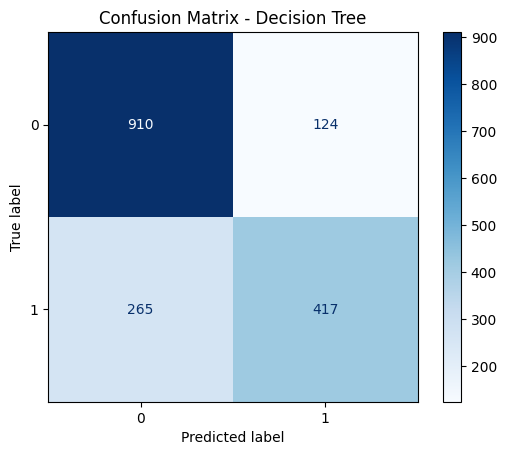

In [32]:
# Verify Results:

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
# Calculate accuracy
print("Test accuracy:", tree_model .score(X_test, y_test))

# Get predicted labels
y_pred = tree_model .predict(X_test)

# Show classification report
#Precision: How many predicted positives were actually positive
#Recall: How many actual positives were correctly predicted
#F1-score: Harmonic mean of precision and recall
#Support: Number of true instances for each class
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tree_model.classes_)
disp.plot(cmap='Blues', values_format='d')  # 'd' = integer format
plt.title("Confusion Matrix - Decision Tree")
plt.show()

**Overall Model Performance**

Test accuracy: 0.7731 (~77%)

**Classification Report Breakdown**

| Class | Label Meaning      | Precision | Recall | F1-score | Support |
| ----- | ------------------ | --------- | ------ | -------- | ------- |
| 0     | Not COVID-positive | 0.77      | 0.88   | 0.82     | 1034    |
| 1     | COVID-positive     | 0.77      | 0.61   | 0.68     | 682     |

**Precision: Of the predicted positives, how many were correct?**

Class 1 (COVID-positive): 77% of predicted positives were actually positive.

**Recall: Of the actual positives, how many were found?**

The model correctly identified 61% of all true positive cases.

**F1-score: Balance between precision and recall**

F1-score for class 1 is 0.68.

**Confusion Matrix Breakdown**

|                         | Predicted 0 (Negative) | Predicted 1 (Positive) |
| ----------------------- | ---------------------- | ---------------------- |
| **Actual 0 (Negative)** | **910** (✅ True Neg)   | **124** (❌ False Pos)  |
| **Actual 1 (Positive)** | **265** (❌ False Neg)  | **417** (✅ True Pos)   |


**Interpretation:**

The model correctly identified 910 negative and 417 positive cases.

It mistakenly predicted 265 actual positives as negative (false negatives) and 124 negatives as positive (false positives).

#### Summary

The tuned Decision Tree model achieved an accuracy of approximately 77%, with a balanced precision of 77% for both COVID-positive and negative classes. It correctly identified 417 out of 682 actual positives (recall = 61%) and 910 out of 1034 negatives. The model demonstrates a reasonable balance between precision and recall, yielding an F1-score of 0.68 for the positive class.


### KNN (KNearestNeighbour)

#### Split features

In [33]:
# Separate features and target from the KNN-processed dataset
X = df_KNN.drop(columns=['covid19_positive'])  # Input features
y = df_KNN['covid19_positive']                 # Target label (0 or 1)

# Split the data into 70% training and 30% testing sets
# random_state ensures reproducibility
# stratify=y maintains the original class distribution in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

#### KNN Gridsearch best parameters

In [34]:
from sklearn.neighbors import KNeighborsClassifier

# Define a grid of hyperparameters to search over
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],     # Number of neighbors to consider
    'weights': ['uniform', 'distance'], # Weighting scheme: equal or distance-based
    'p': [1, 2]                          # Distance metric: 1 = Manhattan, 2 = Euclidean
}

# Set up grid search with 5-fold cross-validation and F1-score as the evaluation metric
knn_grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1  # Use all CPU cores for faster computation
)

# Fit the model on the training data to find the best combination of parameters
knn_grid.fit(X_train, y_train)

# Display the best parameter combination and corresponding F1 score
print("Best KNN Parameters:", knn_grid.best_params_)
print("Best F1 Score (CV):", knn_grid.best_score_)

Best KNN Parameters: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Best F1 Score (CV): 0.672152703996991


#### Fit KNN

In [35]:
# Create and train the KNN classifier using the best parameters found in grid search
knn_model = KNeighborsClassifier(
    n_neighbors=7,    # Optimal number of neighbors (from grid search)
    p=1,              # Manhattan Distance
    weights='distance' # All neighbors contribute equally
)

# Fit the model to the training data
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7, p=1, weights='distance')

#### Summarise Results

Test accuracy: 0.7593240093240093

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.88      0.81      1034
           1       0.76      0.58      0.66       682

    accuracy                           0.76      1716
   macro avg       0.76      0.73      0.74      1716
weighted avg       0.76      0.76      0.75      1716



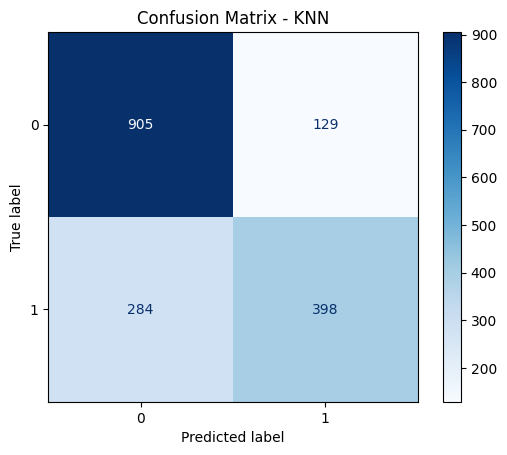

In [36]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Print test set accuracy
print("Test accuracy:", knn_model.score(X_test, y_test))

# Predict labels on the test set
y_pred = knn_model.predict(X_test)

# Generate and print the classification report
# Includes precision, recall, F1-score, and support (sample count) for each class
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix with labels and formatted values
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_model.classes_)
disp.plot(cmap='Blues', values_format='d')  # Use 'd' for integer formatting
plt.title("Confusion Matrix - KNN")
plt.show()

**Overall Model Performance**

Test accuracy: 0.7593 (~76%)

**Classification Report Breakdown**

| Class | Label Meaning      | Precision | Recall | F1-score | Support |
| ----- | ------------------ | --------- | ------ | -------- | ------- |
| 0     | Not COVID-positive | 0.76      | 0.88   | 0.81     | 1034    |
| 1     | COVID-positive     | 0.76      | 0.58   | 0.66     | 682     |



**Precision: Of the predicted positives, how many were correct?**

Class 1 (COVID-positive): 76% of predicted positives were actually positive.

**Recall: Of the actual positives, how many were found?**

The model correctly identified 58% of all true positive cases.

**F1-score: Balance between precision and recall**

F1-score for class 1 is 0.66, indicating a fair balance — though slightly lower than the Decision Tree model.

**Confusion Matrix Breakdown**

|                         | Predicted 0 (Negative) | Predicted 1 (Positive) |
| ----------------------- | ---------------------- | ---------------------- |
| **Actual 0 (Negative)** | **905** (✅ True Neg)   | **129** (❌ False Pos)  |
| **Actual 1 (Positive)** | **284** (❌ False Neg)  | **398** (✅ True Pos)   |


**Interpretation:**

The model correctly identified 905 negative and 398 positive cases.

It mistakenly predicted 284 actual positives as negative (false negatives) and 129 negatives as positive (false positives).


#### Summary

Both the Decision Tree and K-Nearest Neighbors (KNN) classifiers achieved a comparable overall accuracy of approximately 77% and 76%, respectively. The Decision Tree model demonstrated a stronger balance between precision and recall for the COVID-positive class, achieving a recall of 61% and an F1-score of 0.68. This indicates it was more effective at identifying positive cases, resulting in fewer false negatives (265).

In contrast, the KNN model achieved a slightly lower precision of 76% for the positive class and a recall of 58%, yielding an F1-score of 0.66. Although its precision was still respectable, the model produced more false negatives (284), missing more actual positive cases than the Decision Tree.

While both models performed similarly overall, the Decision Tree’s higher recall and slightly stronger F1-score for the COVID-positive class make it the more suitable choice in scenarios where correctly identifying as many positive cases as possible is the primary concern.

| Metric                  | Decision Tree | KNN   |
| ----------------------- | ------------- | ----- |
| **Accuracy**            | **77.3%**        | 75.9% |
| **Precision (Class 1)** | **77%**         | 76%   |
| **Recall (Class 1)**    | **61%**      | 58%   |
| **F1-score (Class 1)**  | **0.68**     | 0.66  |
| **False Positives**     | **124**          | 129   |
| **False Negatives**     | **265**     | 284   |


## Performance evaluation
(Evaluate the prediction performance of the two classification models with the best parameter setting. Based on the performance, choose a model as your final predictive model. Justify your choice)



Two classification models were developed and evaluated: a Decision Tree and a K-Nearest Neighbors (KNN) classifier. Both models were trained on the same processed dataset, with careful attention paid to appropriate feature encoding. Ordinal features such as income, smoking, and working were encoded using custom numerical scales to preserve their order, while nominal features such as blood type and age group were one-hot encoded. Hyperparameter tuning was performed using grid search with 5-fold cross-validation to ensure optimal model performance.

The Decision Tree model was trained using the following best parameters:

```
DecisionTreeClassifier(
    criterion='entropy',
    max_depth=5,
    min_samples_leaf=5,
    min_samples_split=10,
    class_weight='balanced',
    random_state=42
)
```

This model achieved an overall accuracy of 77.3%, with precision of 77%, recall of 61%, and an F1-score of 0.68 for the COVID-positive class. It correctly identified 417 out of 682 positive cases and produced 265 false negatives.

The KNN model was also tuned using grid search and implemented with the following best parameters:

```
KNeighborsClassifier(
    n_neighbors=7,
    p=1,  # Manhattan distance
    weights='distance'
)
```
The KNN model achieved an overall accuracy of 75.9%, with precision of 76%, recall of 58%, and an F1-score of 0.66 for the positive class. It correctly identified 398 positive cases but missed more (284 false negatives), and produced 129 false positives.

While both models delivered similar results, the Decision Tree demonstrated a stronger balance between precision and recall, particularly for the COVID-positive class. This makes it more effective at identifying positive cases while managing false negatives—a critical consideration in public health settings. For this reason, the Decision Tree model was selected as the final predictive model.

